Full Name: Behzad Yousefipour

Student Number: 401300033

In [1]:
import numpy as np
import math
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = 'cpu'

In [32]:
# Data loading with label as one-hot array

training_data = datasets.FashionMNIST(
    root="data", # the root directory to save the downloaded dataset
    train=True, # choose whether it is test or train
    download=True, # choose whether to download the dataset or not 
    transform=ToTensor(), # what transforms should be applied to the dataset, in this case it just 
                          # converts the images to torch.tensor
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

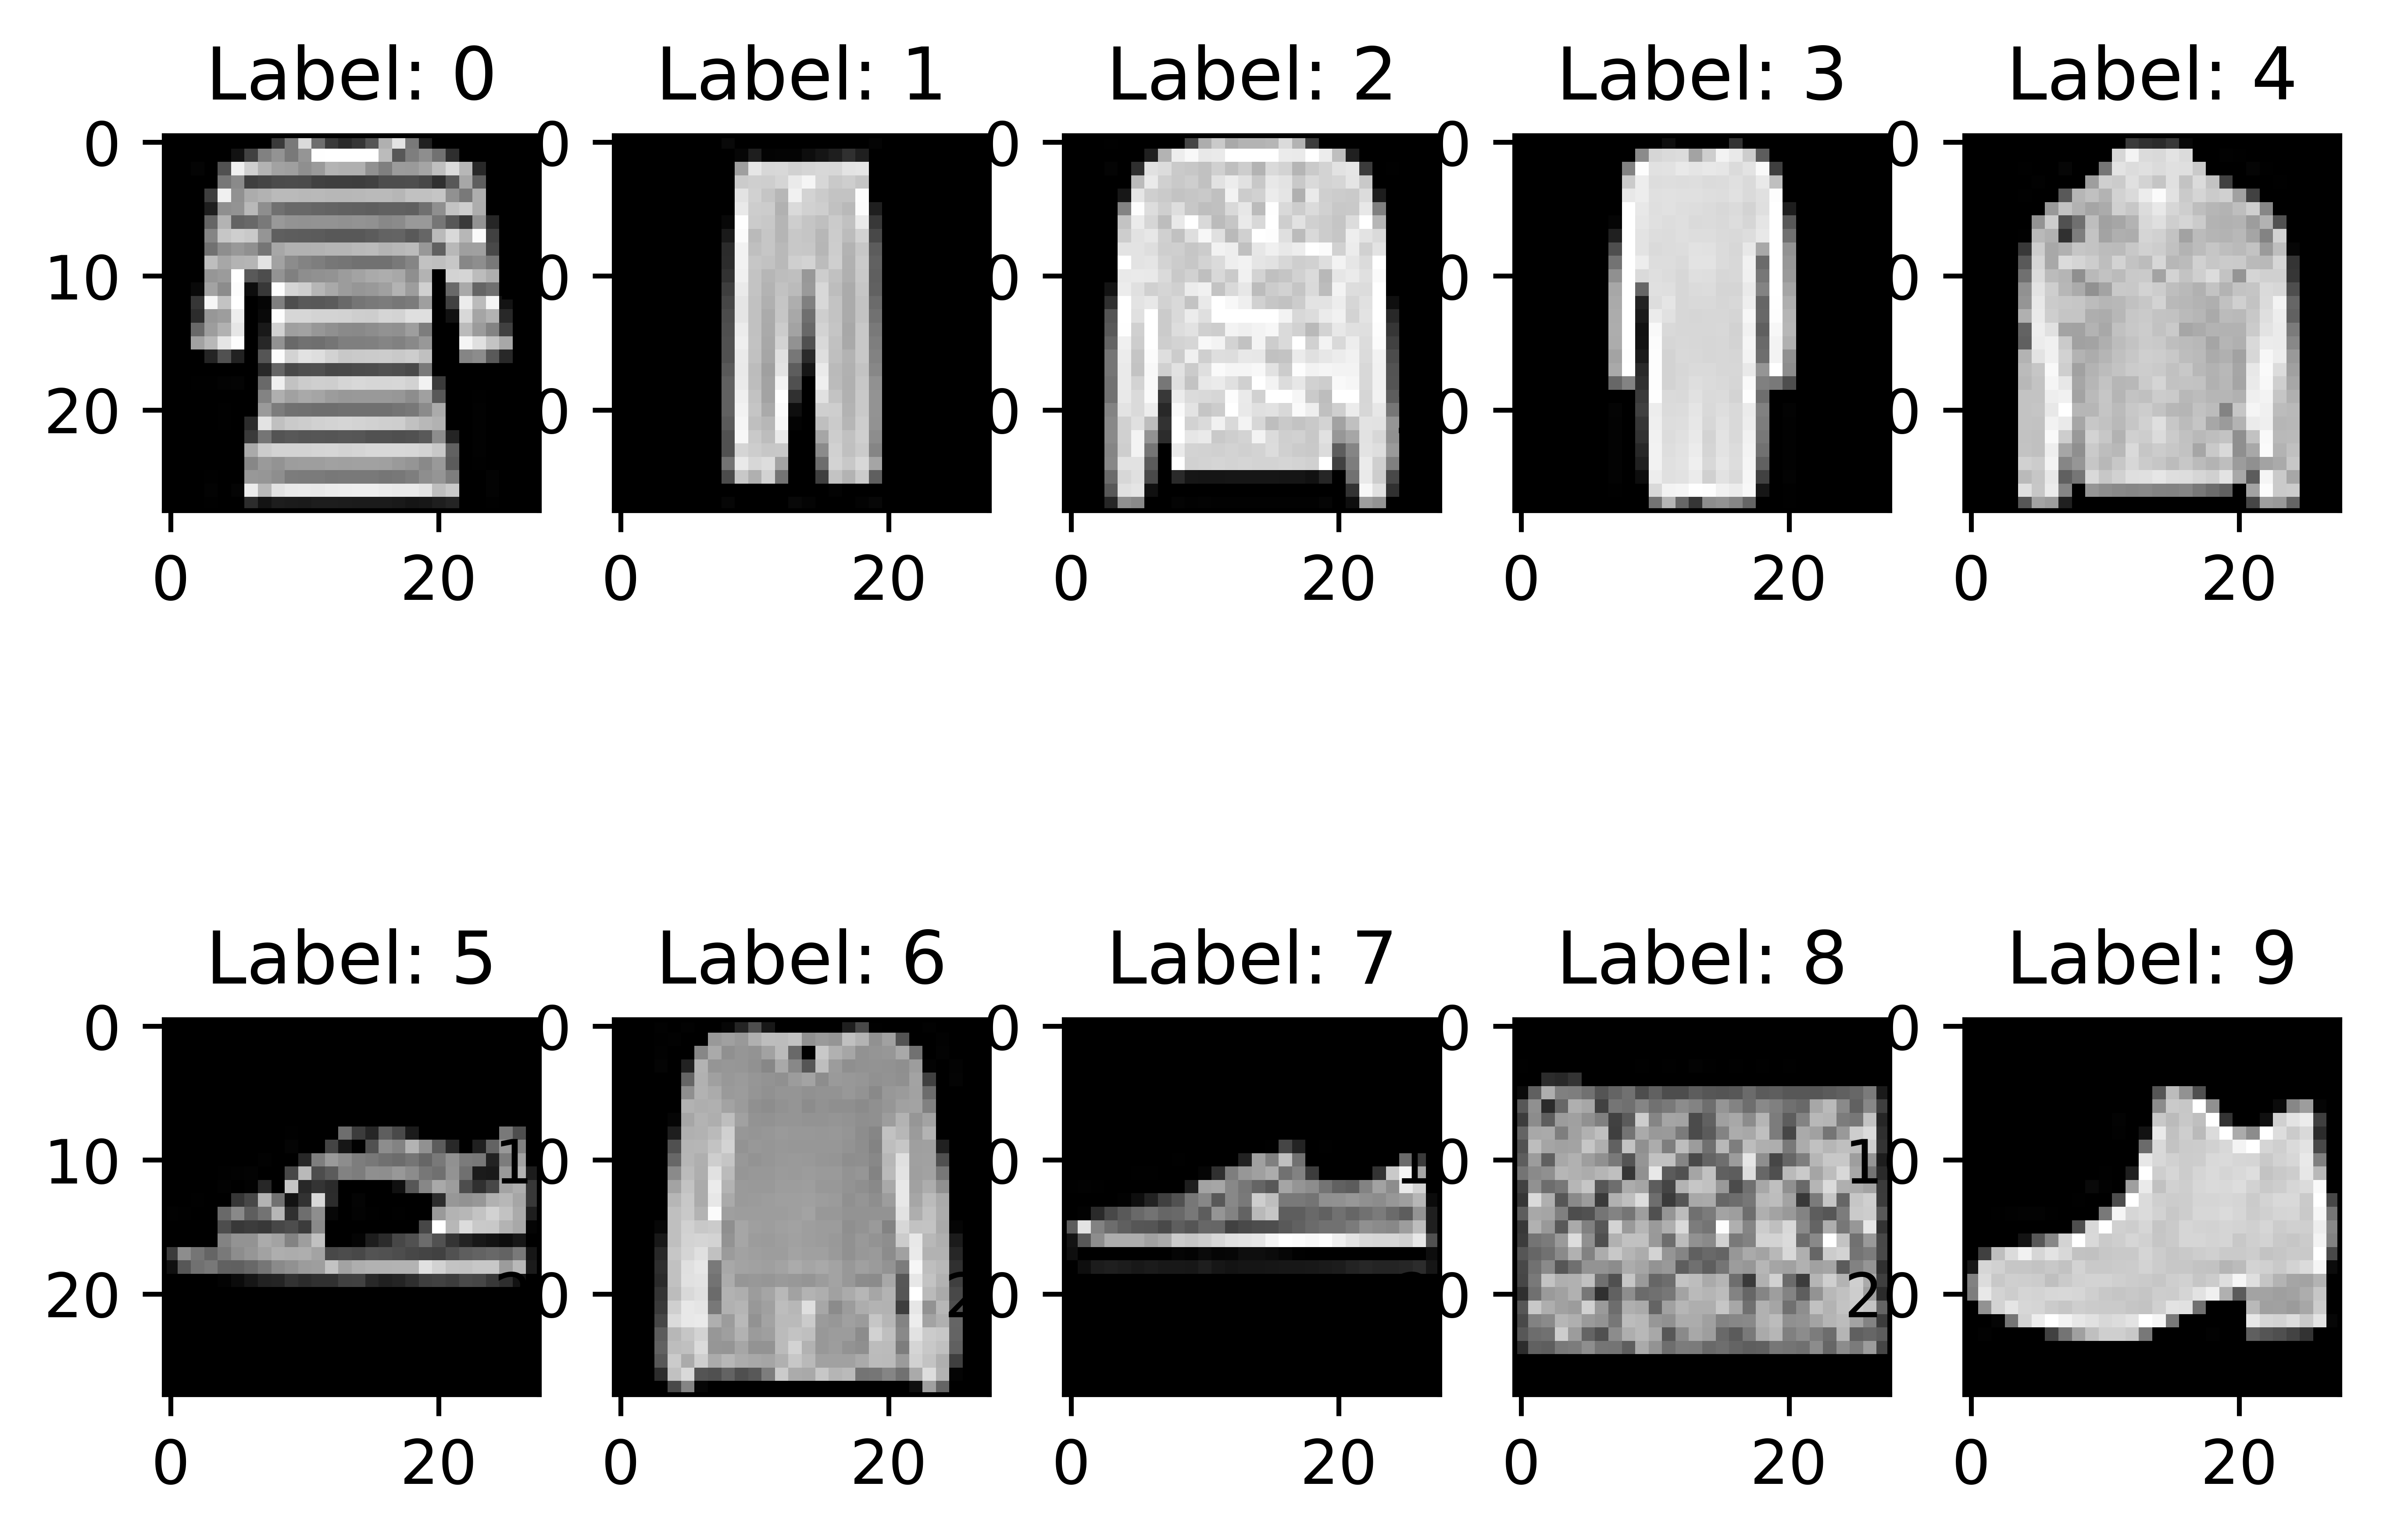

In [33]:
# Data image show:

n = 1
plt.figure(dpi = 1000)
for i in range(10):
    for j in range(30):
        r = training_data[j][1].argmax(0)
        if i == r:    
            plt.subplot(2, 5, n)
            plt.title("Label: "+str(i))
            plt.imshow(training_data[j][0].squeeze(),cmap='gray')
    n += 1        

plt.show()

In [7]:
# ReLU and Softmax functions definition:

def RELU(X):
    X[X<0] = 0
    return X
	
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x),axis=-1)

In [21]:
# Hyperparams:

eta = 2*1e-4
epochs = 4
batch_size=64

In [9]:
# Input and output sizes of each layer (We have 2 hidden layer in this problem)

input_dimension = np.array(torch.flatten(training_data[0][0].squeeze()).shape)
l1_neurons = 512
l2_neurons = 512
l3_neurons = 10

In [10]:
# Using dataloader for minibach stochastic gradient decent

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

In [22]:
# Random initialization for weights and biases:

sigma = 16/(input_dimension[0]+l1_neurons)
w1 = np.random.normal(0, sigma, [input_dimension[0],l1_neurons])
w1 = torch.tensor(w1, requires_grad=True).to(device)


sigma =16/(l2_neurons+l1_neurons)
w2 = np.random.normal(0, sigma, [l2_neurons,l1_neurons])
w2 = torch.tensor(w2, requires_grad=True).to(device)


sigma = 16/(l2_neurons+l3_neurons)
w3 = np.random.normal(0, sigma, [l2_neurons, l3_neurons])
w3 = torch.tensor(w3, requires_grad=True).to(device)

 
sigma = 16/(l1_neurons)
b1 = np.random.normal(0, sigma, [1, l1_neurons])
b1 = torch.tensor(b1, requires_grad=True).to(device)


sigma =16/(l1_neurons)
b2 = np.random.normal(0, sigma, [1, l2_neurons])
b2 = torch.tensor(b2, requires_grad=True).to(device)


sigma = 16/(l1_neurons)
b3 = np.random.normal(0, sigma, [1, l3_neurons])
b3 = torch.tensor(b3, requires_grad=True).to(device)

In [12]:
# Model training function:

def train(dataloader) :
    for batch, (X, y) in enumerate(dataloader):
        size = len(train_dataloader.dataset)
     
        # Feed-Forward
    
        # Layer 1
            
        X = torch.flatten(X,start_dim =1,end_dim=-1)
        net1 = torch.add(torch.matmul(X,w1.float()),b1)
        o1 = RELU(net1)

        # Layer 2
                
        net2 = torch.add(torch.matmul(o1,w2),b2)
        o2 = RELU(net2)
  
        # Layer 3
                
        net3 = torch.add(torch.matmul(o2,w3),b3)
        o3 = RELU(net3)

  
        # Soft max
    
        SM = torch.zeros((len(o3),10))
        for i in range(len(o3)):
            SM[i,:] = softmax(o3[i])
            
        J = torch.tensor([0]).to(torch.float32)
        for i in range(len(y)):
            J += torch.log(SM[i,y[i].argmax()])

                
        # Back propagation
        
        J2 = -(1/len(o3))*J

        
        J2.backward()


        b3.data =  b3.data - eta * b3.grad
        b2.data =  b2.data - eta * b2.grad
        b1.data =  b1.data - eta * b1.grad
        
        w3.data =  w3.data - eta * w3.grad
        w2.data =  w2.data - eta * w2.grad
        w1.data =  w1.data - eta * w1.grad
        
        
        if batch % 100 == 0:
            loss, current = J2.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
# Model testing function:

def test(dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    for X, y in dataloader:
            X = torch.flatten(X,start_dim =1,end_dim=-1)
            net1 = torch.add(torch.matmul(X,w1.float()),b1)
            o1 = RELU(net1)

            # Layer 2
                    
            net2 = torch.add(torch.matmul(o1,w2),b2)
            o2 = RELU(net2)
      
            # Layer 3
                    
            net3 = torch.add(torch.matmul(o2,w3),b3)
            o3 = RELU(net3)

      
            # Soft max
        
            pred = torch.zeros((len(o3),10))
            for i in range(len(o3)):
                pred[i,:] = softmax(o3[i])
                
            test_loss = torch.tensor([0]).to(torch.float32)
            
            for i in range(len(y)):
                test_loss -= torch.log(pred[i,y[i].argmax()])
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.int64).sum().item()

    test_loss /= num_batches
    correct /= size
    print("Test Error:  Accuracy: ", 100*correct,'%, and Avg Loss: ', test_loss.item())

In [23]:
# Training and testing phase:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader)
    test(test_dataloader)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303276  [    0/60000]
loss: 2.260807  [ 6400/60000]
loss: 2.146484  [12800/60000]
loss: 1.895278  [19200/60000]
loss: 1.337731  [25600/60000]
loss: 1.507865  [32000/60000]
loss: 1.379479  [38400/60000]
loss: 1.310975  [44800/60000]
loss: 1.417646  [51200/60000]
loss: 0.928000  [57600/60000]
Test Error:  Accuracy:  64.17 %, and Avg Loss:  0.1350710093975067
Epoch 2
-------------------------------
loss: 1.124174  [    0/60000]
loss: 1.104843  [ 6400/60000]
loss: 0.872917  [12800/60000]
loss: 1.122284  [19200/60000]
loss: 0.756244  [25600/60000]
loss: 0.621871  [32000/60000]
loss: 1.003903  [38400/60000]
loss: 0.806004  [44800/60000]
loss: 0.865030  [51200/60000]
loss: 1.144614  [57600/60000]
Test Error:  Accuracy:  71.77 %, and Avg Loss:  0.058409929275512695
Epoch 3
-------------------------------
loss: 1.010359  [    0/60000]
loss: 0.736362  [ 6400/60000]
loss: 0.917413  [12800/60000]
loss: 0.771246  [19200/60000]
loss: 0.783096  [25600/6

The  model is strongly influenced by its hyperparameters, and with a small change or different initialization, the model may fit well or not. my model's accuracy on testing data after 4 epochs of training is 81.4 %

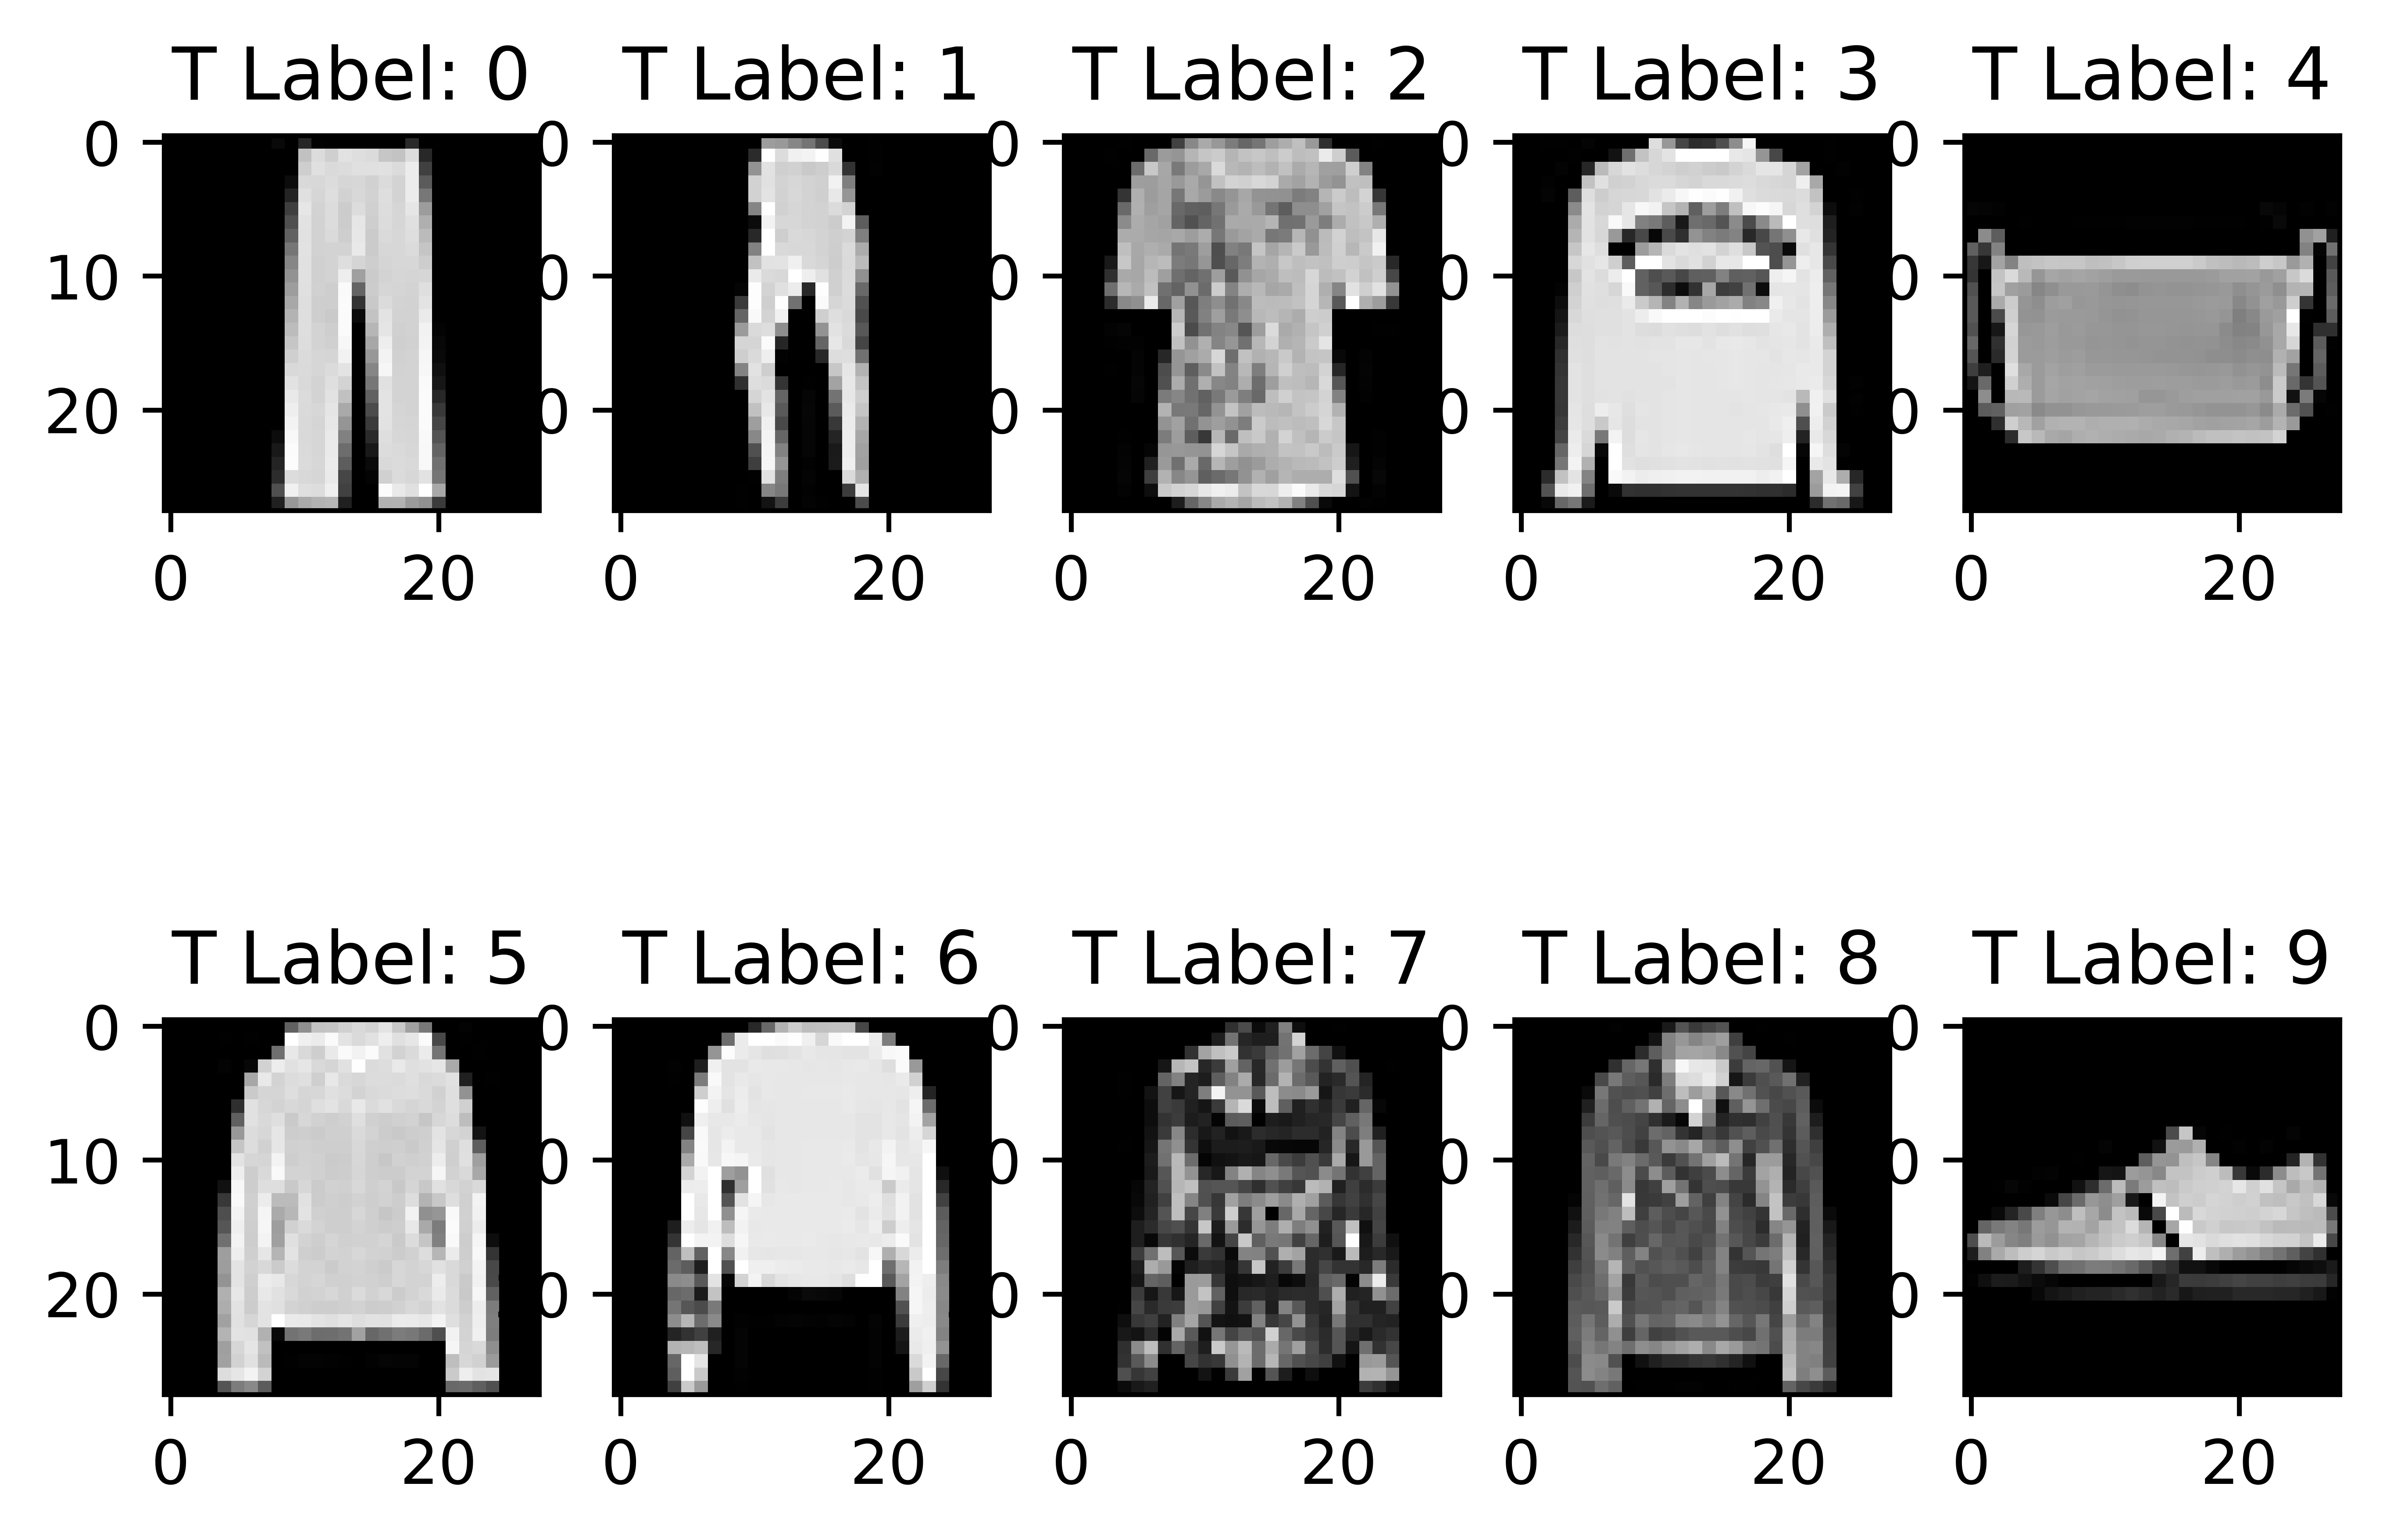

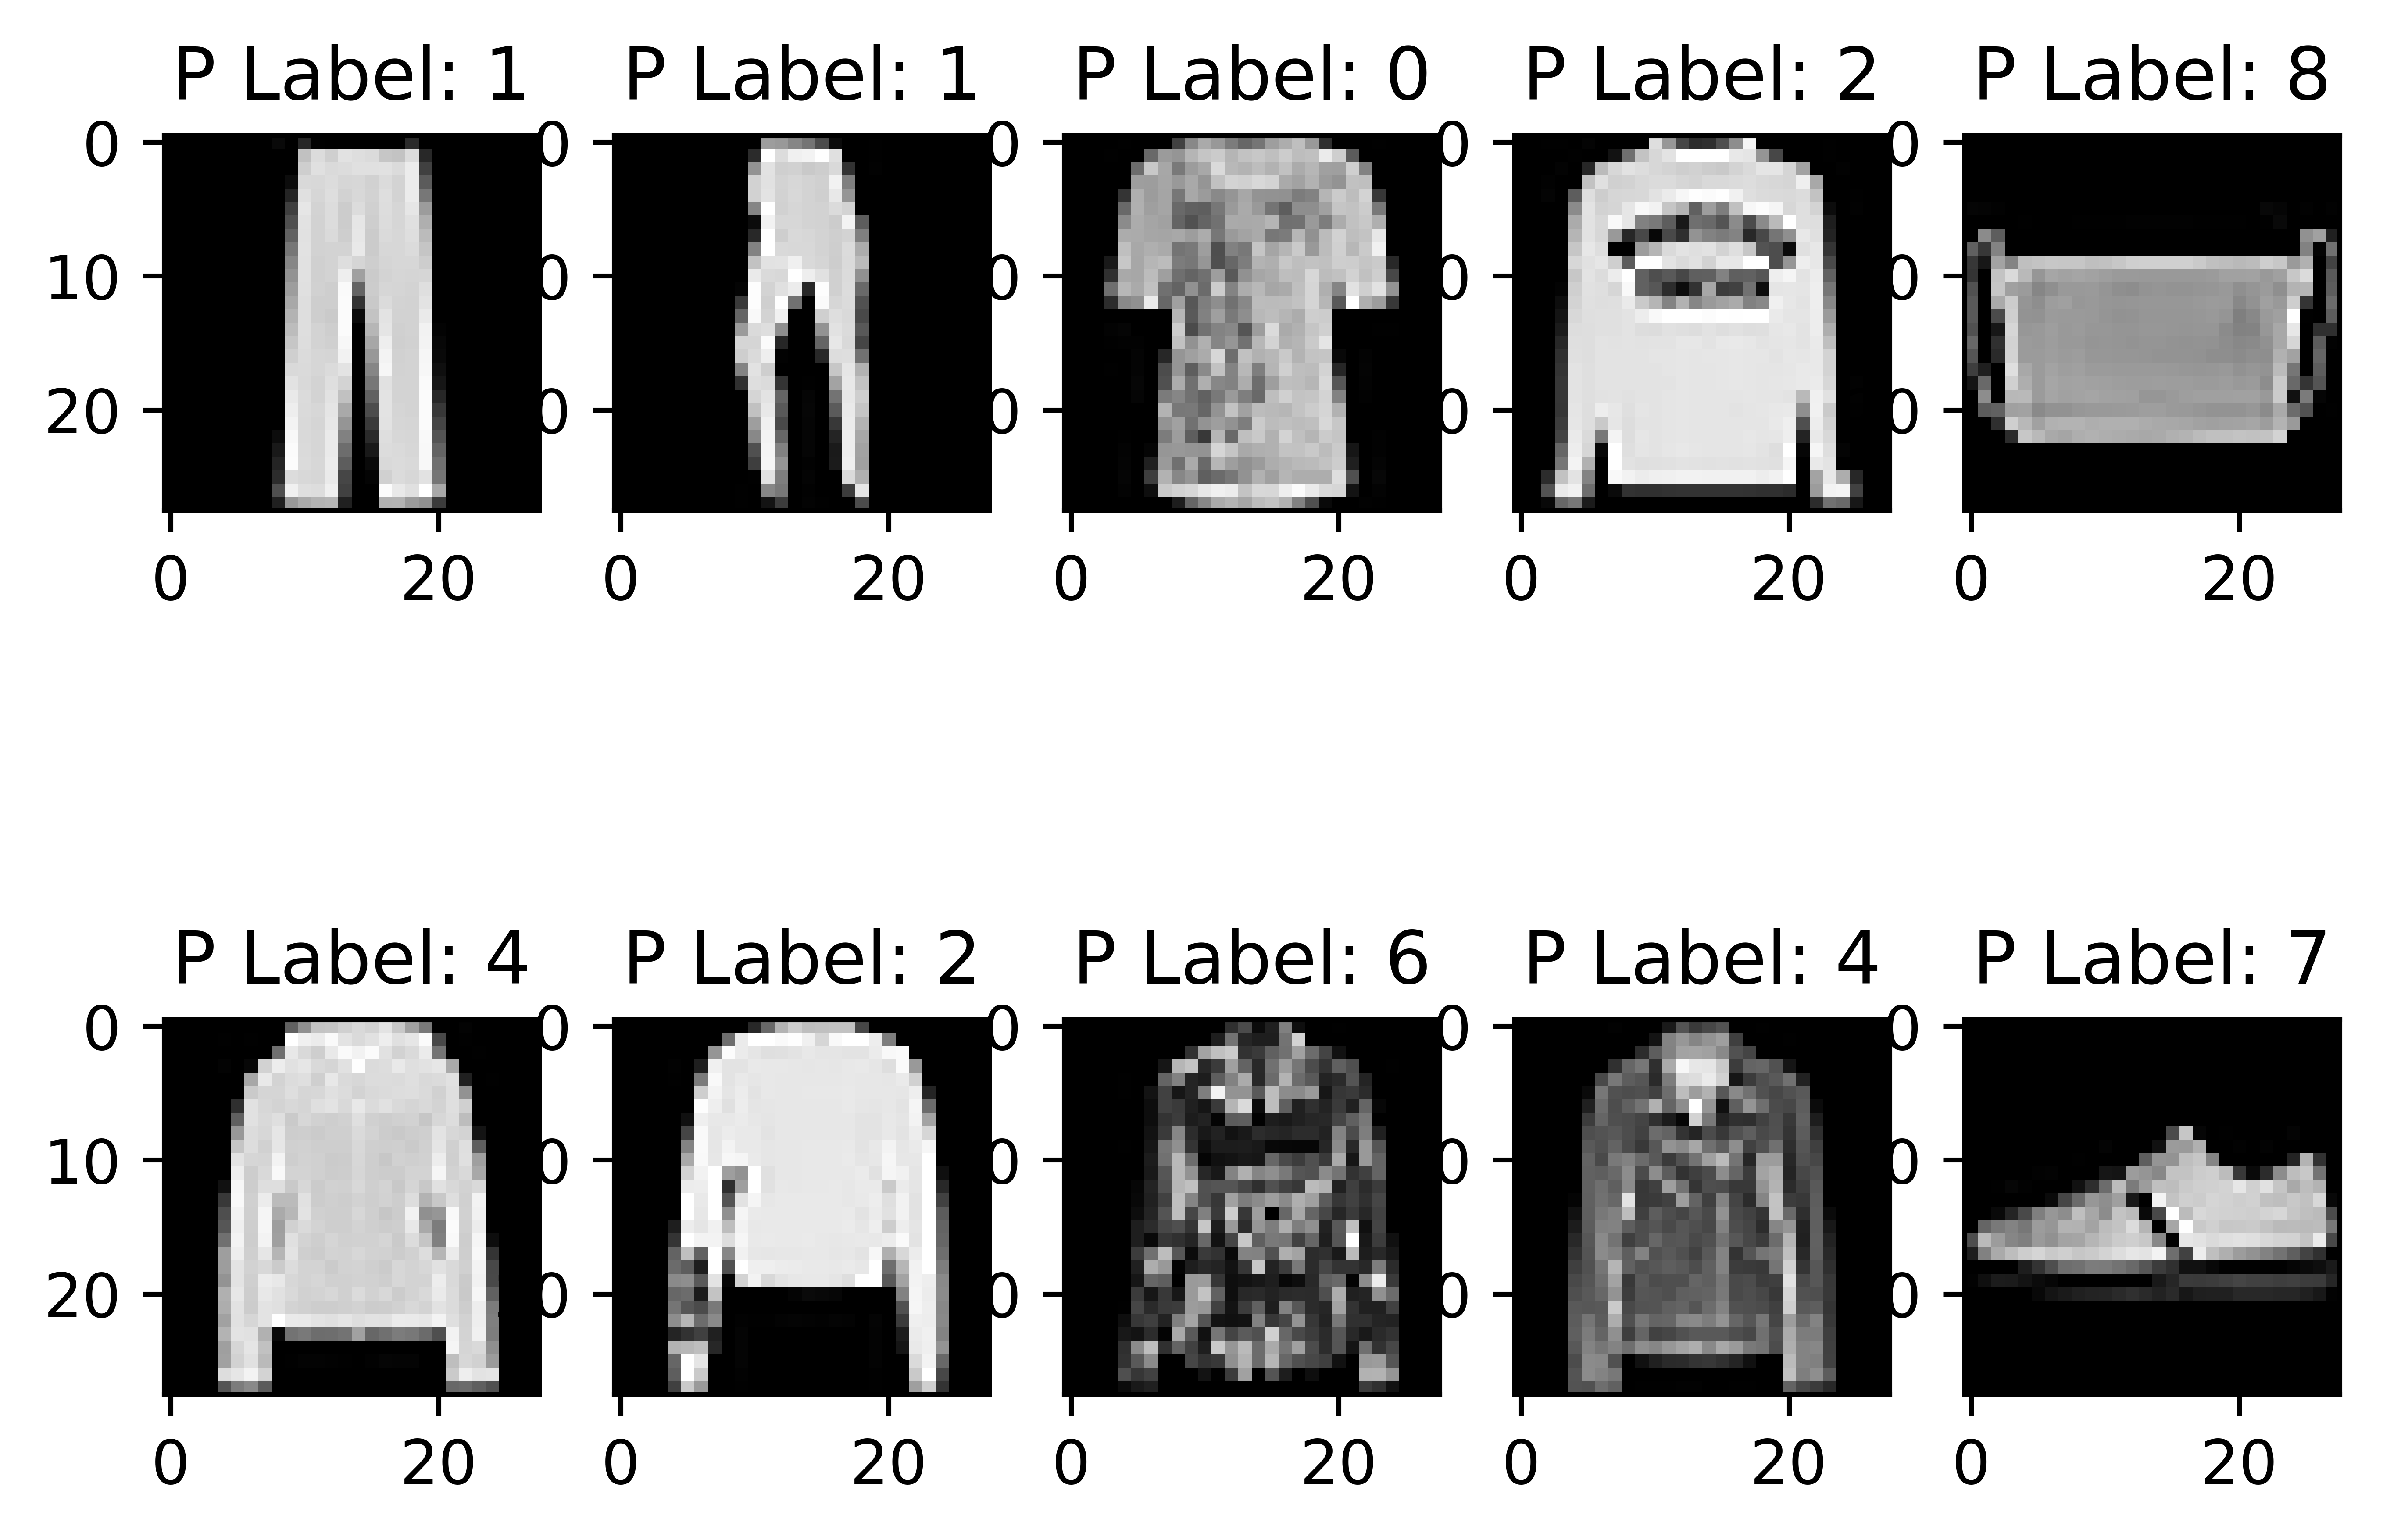

In [68]:
# Data image show after model prediction:

def pred(X):
    
        X = torch.flatten(X,start_dim =1,end_dim=-1)
        
        # layer 1
        
        net1 = torch.add(torch.matmul(X,w1.float()),b1)
        o1 = RELU(net1)

        # Layer 2
                    
        net2 = torch.add(torch.matmul(o1,w2),b2)
        o2 = RELU(net2)
      
        # Layer 3
                    
        net3 = torch.add(torch.matmul(o2,w3),b3)
        o3 = RELU(net3)

      
        # Soft max
        
        return softmax(o3)


# Data image show after model prediction:

n = 1
plt.figure(dpi = 1000)
for i in range(10):
    for j in range(100,150):
        r = test_data[j][1].argmax(0)
        if i == r:    
            plt.subplot(2, 5, n)
            plt.title("T Label: "+str(i))
            plt.imshow(training_data[j][0].squeeze(),cmap='gray')
    n += 1        

plt.show()

n = 1
plt.figure(dpi = 1000)
for i in range(10):
    for j in range(100,150):
        r = test_data[j][1].argmax(0)
        if i == r:    
            plt.subplot(2, 5, n)
            predict = pred(training_data[j][0])           
            plt.title("P Label: "+str(np.array(predict.data.argmax())))
            plt.imshow(training_data[j][0].squeeze(),cmap='gray')
    n += 1        

plt.show()